# Diego Cerretti 2024280040 - Deep Generative Model

# Bernoulli VAE

## Libraries import

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

## Dataset Loading

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


## Dataset Preprocessing

In [4]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = (x_train > 0.5).astype("float32")
x_test = (x_test > 0.5).astype("float32")

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

## Sampling Function

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [6]:
encoder_inputs = layers.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(256, activation="relu")(encoder_inputs)
z_mean = layers.Dense(40, name="z_mean")(x)
z_log_var = layers.Dense(40, name="z_log_var")(x)
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 40)        │     10,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 40)        │     10,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 40)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,520 (865.31 KB)

 Trainable params: 221,520 (865.31 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [7]:
decoder_inputs = layers.Input(shape=(40,), name="z_sampling")
x = layers.Dense(256, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(28 * 28, activation="sigmoid")(x)

decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,984 (828.06 KB)

 Trainable params: 211,984 (828.06 KB)

 Non-trainable params: 0 (0.00 B)

## VAE

In [8]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        reconstruction_loss = tf.keras.backend.binary_crossentropy(inputs, reconstructed)
        reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=1)
        
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(tf.reduce_mean(total_loss))

        return reconstructed

## VAE Compliation

In [9]:
vae_bernoulli = VAE(encoder, decoder)
vae_bernoulli.compile(optimizer="adam")

## VAE Training

In [10]:
history_bernoulli = vae_bernoulli.fit(
    x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - kl_loss: 16.8885 - reconstruction_loss: 205.1619 - total_loss: 222.0505 - val_kl_loss: 25.1494 - val_reconstruction_loss: 102.0244 - val_total_loss: 127.1738
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 26.5145 - reconstruction_loss: 96.4356 - total_loss: 122.9501 - val_kl_loss: 28.8708 - val_reconstruction_loss: 80.7157 - val_total_loss: 109.5864
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 29.0929 - reconstruction_loss: 79.7001 - total_loss: 108.7929 - val_kl_loss: 30.4777 - val_reconstruction_loss: 71.2157 - val_total_loss: 101.6934
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - kl_loss: 30.3444 - reconstruction_loss: 71.2829 - total_loss: 101.6272 - val_kl_loss: 31.7352 - val_reconstruction_loss: 65.9368 - val_total_loss: 97.6719
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - kl_loss: 31.2981 - reconstruction_loss: 66.6016 - total_loss: 97.8997 - val_kl_loss: 31.5986 - 

## Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


<Figure size 2000x800 with 0 Axes>

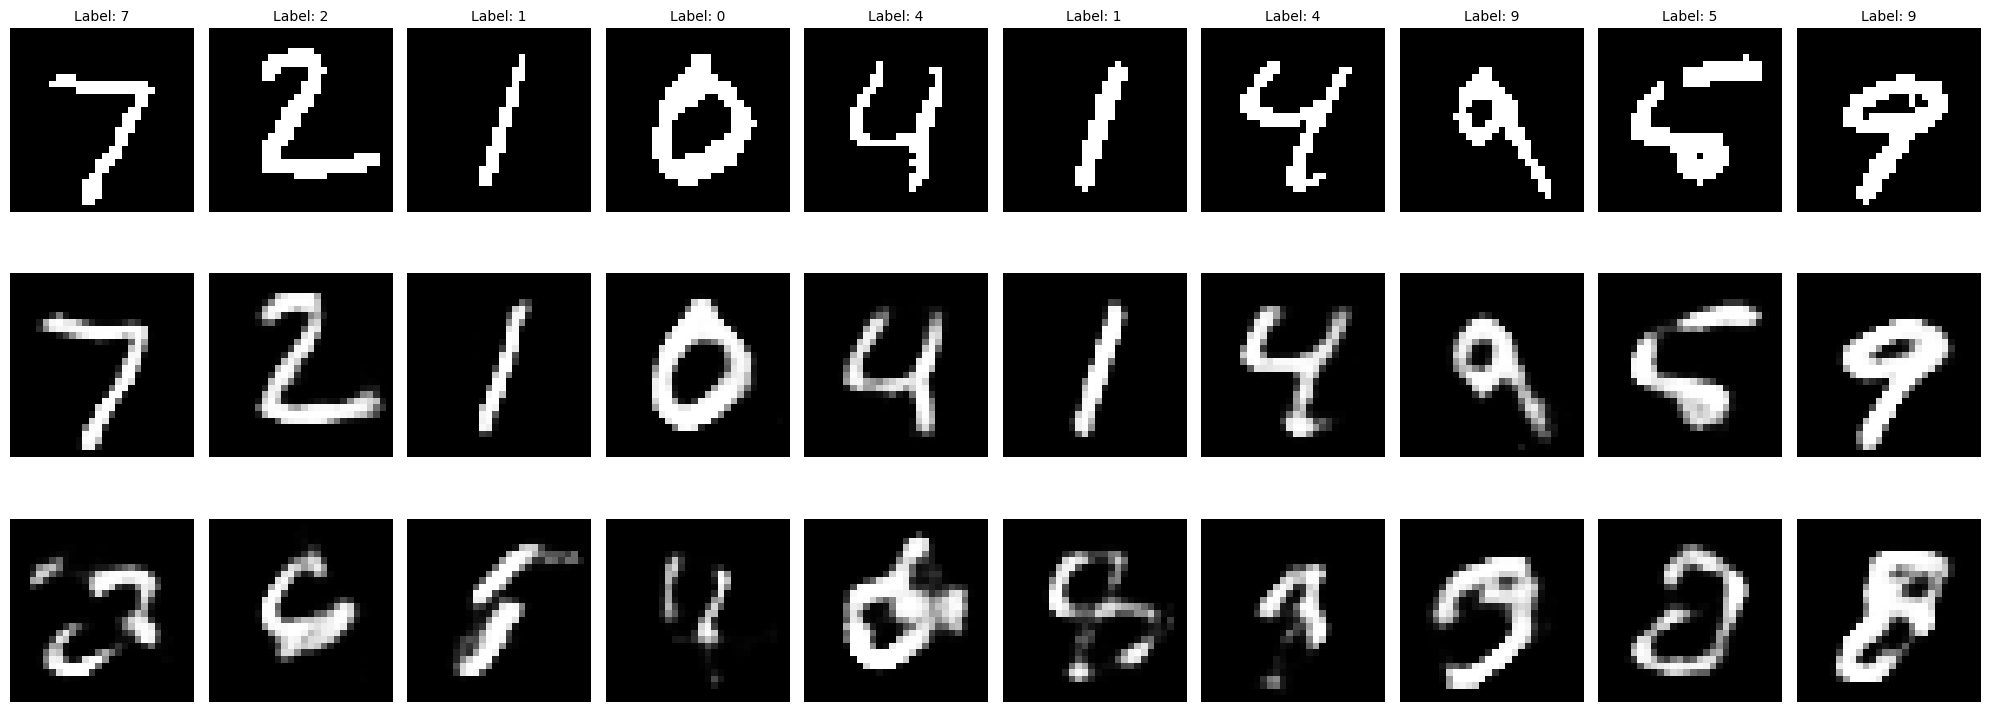

In [11]:
n = 10
decoded_imgs = vae_bernoulli.predict(x_test[:n])
random_latent_vectors = tf.random.normal(shape=(n, 40))
generated_images_bern = vae_bernoulli.decoder.predict(random_latent_vectors)

plt.figure(figsize=(20, 8)) 

plt.figure(figsize=(20, 8))  

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray") 
    if i == 0:
        plt.ylabel("Test", fontsize=16)
    plt.title(f"Label: {y_test[i]}", fontsize=10)  
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.ylabel("Reconstructed", fontsize=16)
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(generated_images_bern[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.ylabel("Generated", fontsize=16)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Gaussian VAE

## Dataset Loading

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
(x_train_original, y_train), (x_test_original, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train_original.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test_original.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


## Dataset Preprocessing

In [13]:
x_train = x_train_original.astype("float32") / 255.0
x_test = x_test_original.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

## Sampling

In [14]:
def sampling(args, sigma=1.0):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0.0, stddev=sigma)  # Adjusted noise
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [15]:
encoder_inputs = layers.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(256, activation="relu")(encoder_inputs)
z_mean = layers.Dense(40, name="z_mean")(x)
z_log_var = layers.Dense(40, name="z_log_var")(x)
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder_gaussian = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder_gaussian")
encoder_gaussian.summary()

Model: "encoder_gaussian"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    200,960 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 40)        │     10,280 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 40)        │     10,280 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 40)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,520 (865.31 KB)

 Trainable params: 221,520 (865.31 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [16]:
decoder_inputs = layers.Input(shape=(40,), name="z_sampling")
x = layers.Dense(256, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(28 * 28, activation="linear")(x)

decoder_gaussian = models.Model(decoder_inputs, decoder_outputs, name="decoder_gaussian")
decoder_gaussian.summary()

Model: "decoder_gaussian"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,984 (828.06 KB)

 Trainable params: 211,984 (828.06 KB)

 Non-trainable params: 0 (0.00 B)

## VAE

In [17]:
class VAE_Gaussian(tf.keras.Model):
    def __init__(self, encoder, decoder, sigma_prior=1.0, beta=1.0, **kwargs):
        super(VAE_Gaussian, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sigma_prior = sigma_prior
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)

        reconstructed = self.decoder(z)

        reconstruction_loss = tf.reduce_sum(tf.square(inputs - reconstructed), axis=1)

        kl_loss = 0.5 * tf.reduce_sum(
            (tf.square(z_mean) / (self.sigma_prior**2))
            + (tf.exp(z_log_var) / (self.sigma_prior**2))
            - 1
            - z_log_var
            + tf.math.log(self.sigma_prior**2),
            axis=1
        )

        total_loss = reconstruction_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(tf.reduce_mean(total_loss))

        return reconstructed

vae_gaussian = VAE_Gaussian(encoder_gaussian, decoder_gaussian)
vae_gaussian.compile(optimizer="adam")

## Training

In [18]:
sigmas = [2.0, 1.0, 0.5]
models = {}

for sigma in sigmas:
    print(f"Training VAE with sigma_prior={sigma}...")
    vae = VAE_Gaussian(encoder_gaussian, decoder_gaussian, sigma_prior=sigma)
    vae.compile(optimizer="adam")

    history = vae.fit(
        x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None)
    )

    models[sigma] = {"model": vae, "history": history}

Training VAE with sigma_prior=2.0...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 10.6009 - reconstruction_loss: 54.4251 - total_loss: 65.0260 - val_kl_loss: 8.1795 - val_reconstruction_loss: 30.8229 - val_total_loss: 39.0024
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 8.4543 - reconstruction_loss: 29.4565 - total_loss: 37.9108 - val_kl_loss: 9.0503 - val_reconstruction_loss: 26.5081 - val_total_loss: 35.5584
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 9.1122 - reconstruction_loss: 26.3756 - total_loss: 35.4878 - val_kl_loss: 9.5309 - val_reconstruction_loss: 25.0345 - val_total_loss: 34.5653
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 9.5162 - reconstruction_loss: 25.0609 - total_loss: 34.5771 - val_kl_loss: 9.8027 - val_reconstruction_loss: 23.9783 - val_total_loss: 33.7810
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 9.7062 - reconstruction_loss: 24.1879 - total_loss: 33.8941 - val_kl_

## Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


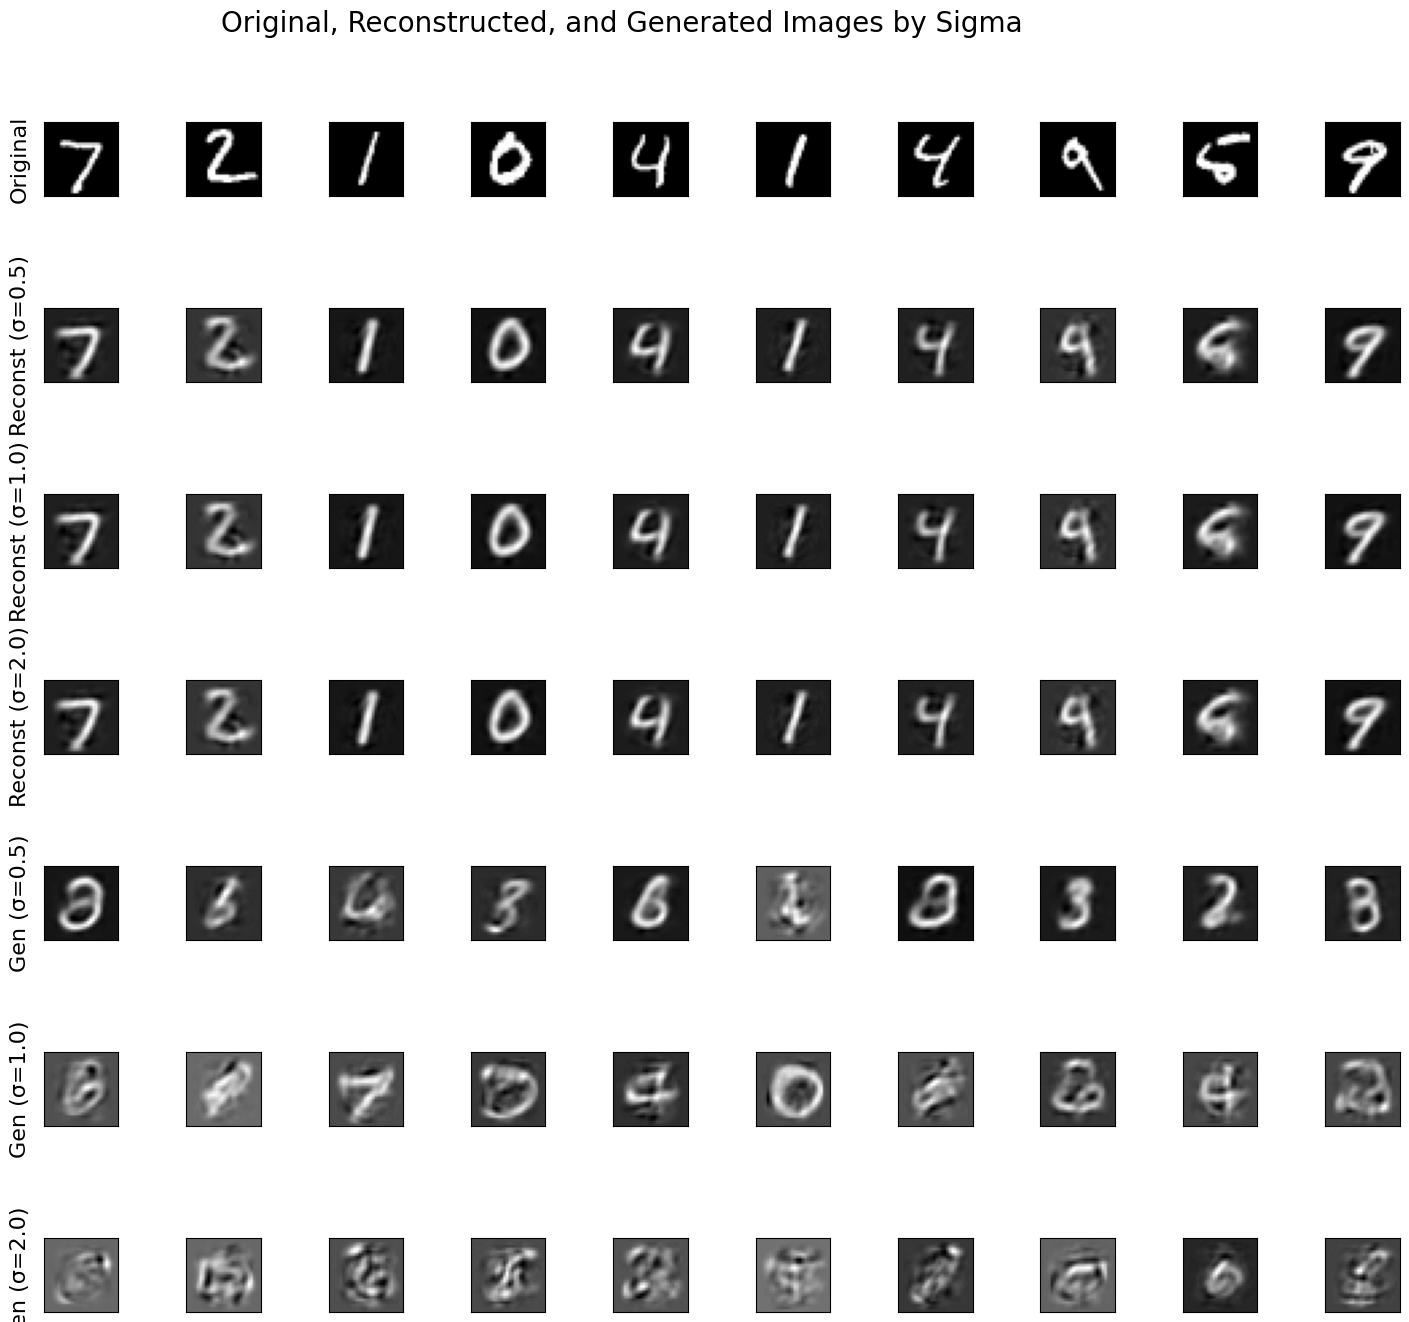

In [24]:
n_samples = 10
sigmas = [0.5, 1.0, 2.0]

n_rows = 1 + len(sigmas) + len(sigmas)
n_cols = n_samples

plt.figure(figsize=(20, n_rows * 2))

for j in range(n_samples):
    ax = plt.subplot(n_rows, n_cols, j + 1)
    ax.imshow(x_test[j].reshape(28, 28), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel("Original", fontsize=16, labelpad=10)

for i, sigma in enumerate(sigmas):
    reconstructed_images = models[sigma]["model"].predict(x_test[:n_samples])
    row = 1 + i
    for j in range(n_samples):
        ax = plt.subplot(n_rows, n_cols, row * n_cols + j + 1)
        ax.imshow(reconstructed_images[j].reshape(28, 28), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(f"Reconst (σ={sigma})", fontsize=16, labelpad=10)

for i, sigma in enumerate(sigmas):
    random_latent_vectors = tf.random.normal(shape=(n_samples, 40), stddev=sigma)
    generated_images = models[sigma]["model"].decoder.predict(random_latent_vectors)
    row = 1 + len(sigmas) + i
    for j in range(n_samples):
        ax = plt.subplot(n_rows, n_cols, row * n_cols + j + 1)
        ax.imshow(generated_images[j].reshape(28, 28), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(f"Gen (σ={sigma})", fontsize=16, labelpad=10)

plt.suptitle("Original, Reconstructed, and Generated Images by Sigma", fontsize=20)

plt.subplots_adjust(left=0.2, hspace=1.5, top=0.9, bottom=0.05)

plt.show()

## Bernoulli vs Gaussian Comparison

## Reconstruction

In [25]:
reconstructed_bernoulli = vae_bernoulli.predict(x_test)
reconstruction_error_bernoulli = np.mean(
    tf.keras.losses.binary_crossentropy(x_test, reconstructed_bernoulli).numpy()
)

reconstructed_gaussian = models[1.0]["model"].predict(x_test)
reconstruction_error_gaussian = np.mean(
    np.mean(np.square(x_test - reconstructed_gaussian), axis=1)
)

print(f"Reconstruction Error (Bernoulli VAE): {reconstruction_error_bernoulli:.4f}")
print(f"Reconstruction Error (Gaussian VAE): {reconstruction_error_gaussian:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction Error (Bernoulli VAE): 0.1007
Reconstruction Error (Gaussian VAE): 0.0244


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


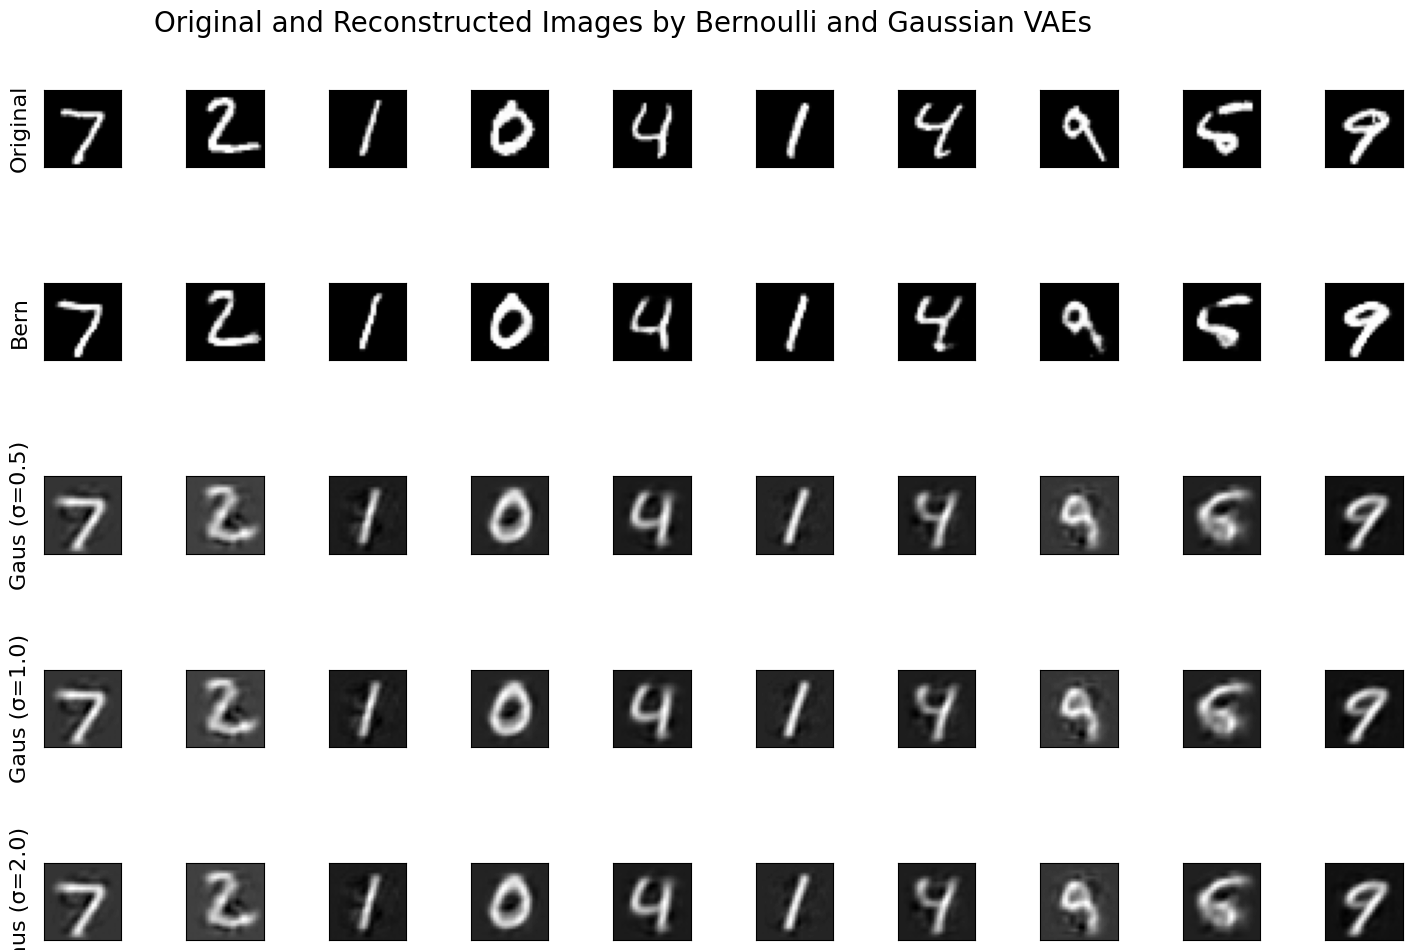

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

n_samples = 10
sigmas = [0.5, 1.0, 2.0]

x_test_batch = x_test[:n_samples]

n_rows = 1 + 1 + len(sigmas)
n_cols = n_samples

plt.figure(figsize=(20, n_rows * 2))

for j in range(n_samples):
    ax = plt.subplot(n_rows, n_cols, j + 1)
    ax.imshow(x_test_batch[j].reshape(28, 28), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel("Original", fontsize=16, labelpad=10)

reconstructed_bern = vae_bernoulli.predict(x_test_batch)
for j in range(n_samples):
    ax = plt.subplot(n_rows, n_cols, n_cols + j + 1)
    ax.imshow(reconstructed_bern[j].reshape(28, 28), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel("Bern", fontsize=16, labelpad=10)

for i, sigma in enumerate(sigmas):
    reconstructed_gaussian = models[sigma]["model"].predict(x_test_batch)
    row = 2 + i
    for j in range(n_samples):
        ax = plt.subplot(n_rows, n_cols, row * n_cols + j + 1)
        ax.imshow(reconstructed_gaussian[j].reshape(28, 28), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(f"Gaus (σ={sigma})", fontsize=16, labelpad=10)

plt.suptitle("Original and Reconstructed Images by Bernoulli and Gaussian VAEs", fontsize=20)
plt.subplots_adjust(left=0.2, hspace=1.5, top=0.9, bottom=0.05)
plt.show()

## Generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


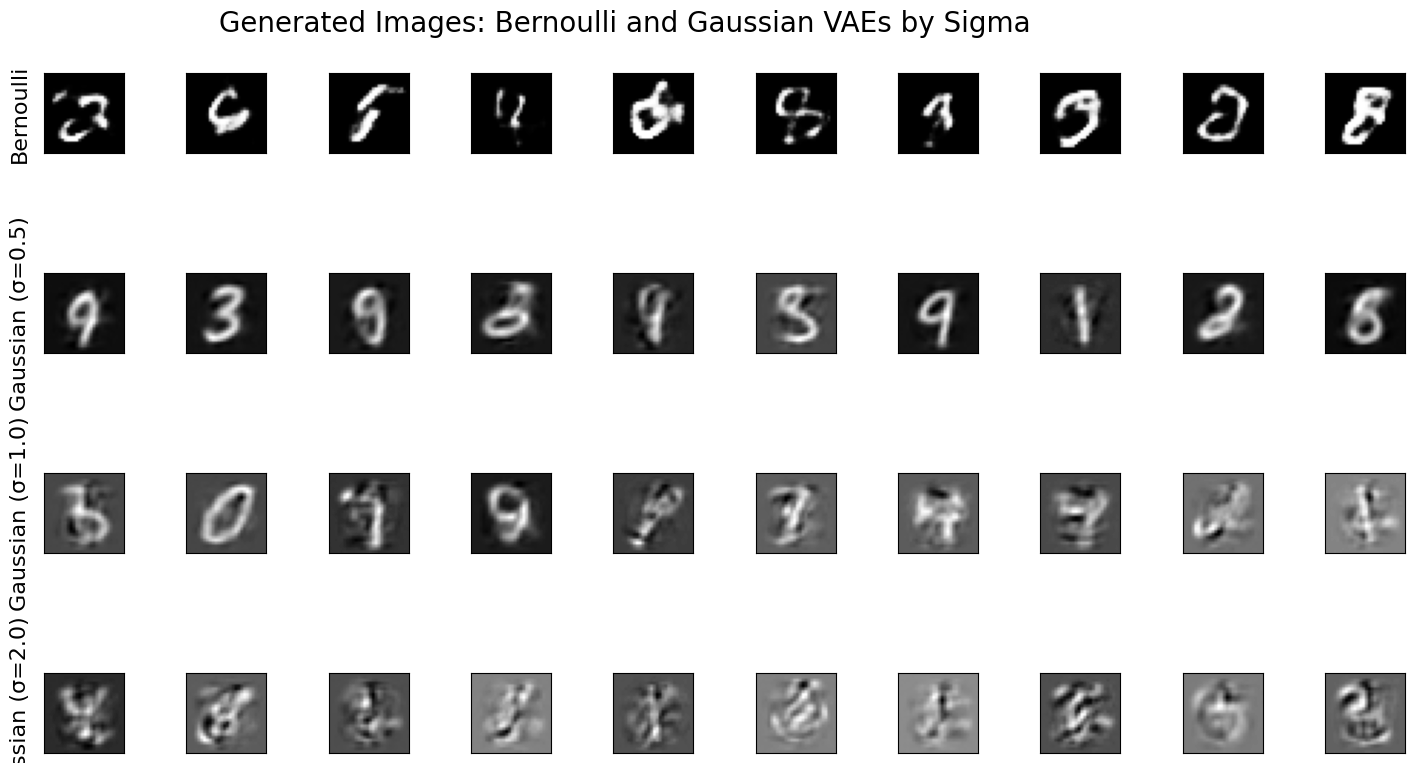

In [32]:
n_samples = 10
sigmas = [0.5, 1.0, 2.0]

np.random.seed(42)
tf.random.set_seed(42)

n_rows = 1 + len(sigmas)
n_cols = n_samples

plt.figure(figsize=(20, n_rows * 2))

for j in range(n_samples):
    ax = plt.subplot(n_rows, n_cols, j + 1)
    ax.imshow(generated_images_bern[j].reshape(28, 28), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
        ax.set_ylabel("Bernoulli", fontsize=16, labelpad=10)

for i, sigma in enumerate(sigmas):
    random_latent_vectors = tf.random.normal(shape=(n_samples, 40), stddev=sigma)
    generated_images = models[sigma]["model"].decoder.predict(random_latent_vectors)
    
    row = 1 + i 
    for j in range(n_samples):
        ax = plt.subplot(n_rows, n_cols, row * n_cols + j + 1)
        ax.imshow(generated_images[j].reshape(28, 28), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(f"Gaussian (σ={sigma})", fontsize=16, labelpad=10)

plt.suptitle("Generated Images: Bernoulli and Gaussian VAEs by Sigma", fontsize=20)
plt.subplots_adjust(left=0.2, hspace=1.5, top=0.9, bottom=0.05)
plt.show()

## Latent Space Structure

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


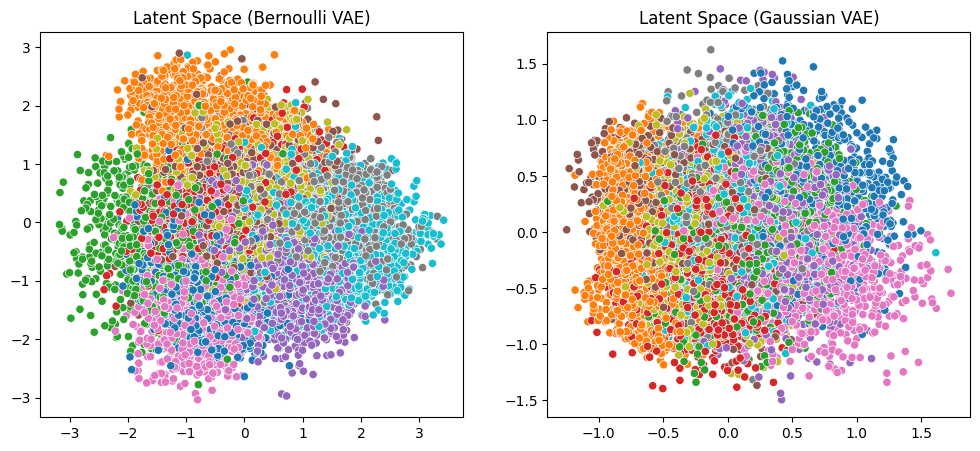

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns

z_mean_bernoulli, _, _ = vae_bernoulli.encoder.predict(x_test)
z_mean_gaussian, _, _ = models[1.0]["model"].encoder.predict(x_test)

pca_bernoulli = PCA(n_components=2).fit_transform(z_mean_bernoulli)
pca_gaussian = PCA(n_components=2).fit_transform(z_mean_gaussian)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_bernoulli[:, 0], y=pca_bernoulli[:, 1], hue=y_test, palette="tab10", legend=None)
plt.title("Latent Space (Bernoulli VAE)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_gaussian[:, 0], y=pca_gaussian[:, 1], hue=y_test, palette="tab10", legend=None)
plt.title("Latent Space (Gaussian VAE)")
plt.show()

## Diversity

In [ ]:
diversity_bernoulli = np.var(generated_images_bern, axis=0).mean()
diversity_gaussian = np.var(generated_images, axis=0).mean()

print(f"Diversity (Bernoulli VAE): {diversity_bernoulli:.4f}")
print(f"Diversity (Gaussian VAE): {diversity_gaussian:.4f}")

Diversity (Bernoulli VAE): 0.0357
Diversity (Gaussian VAE): 0.0230
